# Method 3 - Rest Ideas After 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

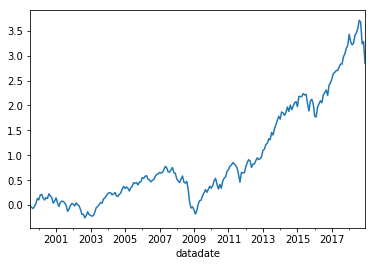

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.136512
2000-12-31   -0.046712
2001-12-31   -0.045799
2002-12-31   -0.216252
2003-12-31    0.464454
2004-12-31    0.158756
2005-12-31    0.068905
2006-12-31    0.104058
2007-12-31    0.009287
2008-12-31   -0.410291
2009-12-31    0.428507
2010-12-31    0.216786
2011-12-31   -0.017589
2012-12-31    0.196724
2013-12-31    0.410118
2014-12-31    0.106356
2015-12-31   -0.016480
2016-12-31    0.140204
2017-12-31    0.218257
2018-12-31   -0.085804
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3234.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.84e-200
Time:                        13:42:33   Log-Likelihood:                 846.93
No. Observations:                 234   AIC:                            -1684.
Df Residuals:                     229   BIC:                            -1667.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.838      0.000       0.001       0.003
mktrf          1.0164      0.012     83.134      0.000       0.992       1.040
me             0.2536      0.014     17.830      0.000       0.226       0.282
ia             0.0444      0.022      2.054      0.041       0.002       0.087
roe           -0.0841      0.019     -4.543      0.000      -0.121      -0.048
==============================================================================
Omnibus:                       29.304   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.878
Skew:                          -0.229   Prob(JB):                     7.74e-33
Kurtosis:                       6.868   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1809.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.02e-172
Time:                        13:42:33   Log-Likelihood:                 846.93
No. Observations:                 234   AIC:                            -1684.
Df Residuals:                     229   BIC:                            -1667.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.534      0.000       0.001       0.003
mktrf          1.0164      0.014     71.403      0.000       0.988       1.044
me             0.2536      0.021     12.107      0.000       0.213       0.295
ia             0.0444      0.041      1.094      0.274      -0.035       0.124
roe           -0.0841      0.029     -2.917      0.004      -0.141      -0.028
==============================================================================
Omnibus:                       29.304   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.878
Skew:                          -0.229   Prob(JB):                     7.74e-33
Kurtosis:                       6.868   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2087.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.54e-179
Time:                        13:42:33   Log-Likelihood:                 846.93
No. Observations:                 234   AIC:                            -1684.
Df Residuals:                     229   BIC:                            -1667.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.591      0.000       0.001       0.003
mktrf          1.0164      0.014     72.521      0.000       0.989       1.044
me             0.2536      0.020     12.766      0.000       0.215       0.292
ia             0.0444      0.041      1.076      0.282      -0.036       0.125
roe           -0.0841      0.032     -2.613      0.009      -0.147      -0.021
==============================================================================
Omnibus:                       29.304   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.878
Skew:                          -0.229   Prob(JB):                     7.74e-33
Kurtosis:                       6.868   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2207.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.54e-191
Time:                        13:42:33   Log-Likelihood:                 829.18
No. Observations:                 234   AIC:                            -1646.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.825      0.000       0.001       0.003
mktrf          1.0344      0.013     78.103      0.000       1.008       1.061
smb            0.2766      0.017     15.827      0.000       0.242       0.311
hml            0.0219      0.021      1.062      0.289      -0.019       0.062
rmw           -0.0609      0.023     -2.612      0.010      -0.107      -0.015
cma            0.0430      0.030      1.451      0.148      -0.015       0.101
==============================================================================
Omnibus:                       29.348   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.669
Skew:                          -0.009   Prob(JB):                     1.18e-38
Kurtosis:                       7.233   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1924.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.33e-184
Time:                        13:42:33   Log-Likelihood:                 829.18
No. Observations:                 234   AIC:                            -1646.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.593      0.000       0.001       0.003
mktrf          1.0344      0.015     69.681      0.000       1.005       1.064
smb            0.2766      0.023     12.093      0.000       0.232       0.321
hml            0.0219      0.046      0.476      0.634      -0.068       0.112
rmw           -0.0609      0.031     -1.955      0.051      -0.122       0.000
cma            0.0430      0.042      1.031      0.303      -0.039       0.125
==============================================================================
Omnibus:                       29.348   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.669
Skew:                          -0.009   Prob(JB):                     1.18e-38
Kurtosis:                       7.233   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2463.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.50e-196
Time:                        13:42:33   Log-Likelihood:                 829.18
No. Observations:                 234   AIC:                            -1646.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.487      0.000       0.001       0.003
mktrf          1.0344      0.014     71.768      0.000       1.006       1.063
smb            0.2766      0.021     13.211      0.000       0.236       0.318
hml            0.0219      0.048      0.461      0.645      -0.071       0.115
rmw           -0.0609      0.034     -1.773      0.076      -0.128       0.006
cma            0.0430      0.040      1.077      0.281      -0.035       0.121
==============================================================================
Omnibus:                       29.348   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.669
Skew:                          -0.009   Prob(JB):                     1.18e-38
Kurtosis:                       7.233   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2565.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.65e-189
Time:                        13:42:33   Log-Likelihood:                 820.34
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     229   BIC:                            -1613.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.925      0.000       0.001       0.003
mktrf          1.0293      0.013     81.623      0.000       1.004       1.054
smb            0.2933      0.016     18.635      0.000       0.262       0.324
hml            0.0671      0.016      4.293      0.000       0.036       0.098
umd           -0.0353      0.010     -3.443      0.001      -0.056      -0.015
==============================================================================
Omnibus:                       25.378   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.920
Skew:                          -0.062   Prob(JB):                     2.03e-27
Kurtosis:                       6.549   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2072.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.75e-178
Time:                        13:42:33   Log-Likelihood:                 820.34
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     229   BIC:                            -1613.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.250      0.001       0.001       0.003
mktrf          1.0293      0.017     62.042      0.000       0.997       1.062
smb            0.2933      0.020     14.723      0.000       0.254       0.332
hml            0.0671      0.044      1.521      0.128      -0.019       0.154
umd           -0.0353      0.018     -1.942      0.052      -0.071       0.000
==============================================================================
Omnibus:                       25.378   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.920
Skew:                          -0.062   Prob(JB):                     2.03e-27
Kurtosis:                       6.549   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2437.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.30e-186
Time:                        13:42:33   Log-Likelihood:                 820.34
No. Observations:                 234   AIC:                            -1631.
Df Residuals:                     229   BIC:                            -1613.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.143      0.002       0.001       0.003
mktrf          1.0293      0.015     69.852      0.000       1.000       1.058
smb            0.2933      0.020     14.708      0.000       0.254       0.332
hml            0.0671      0.049      1.372      0.170      -0.029       0.163
umd           -0.0353      0.015     -2.342      0.019      -0.065      -0.006
==============================================================================
Omnibus:                       25.378   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.920
Skew:                          -0.062   Prob(JB):                     2.03e-27
Kurtosis:                       6.549   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1466.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-97
Time:                        13:42:33   Log-Likelihood:                 415.55
No. Observations:                 120   AIC:                            -821.1
Df Residuals:                     115   BIC:                            -807.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.697      0.000       0.001       0.004
mktrf          1.0141      0.020     50.790      0.000       0.975       1.054
me             0.2367      0.020     12.002      0.000       0.198       0.276
ia             0.0843      0.031      2.729      0.007       0.023       0.145
roe           -0.0970      0.027     -3.551      0.001      -0.151      -0.043
==============================================================================
Omnibus:                       12.841   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               31.711
Skew:                          -0.281   Prob(JB):                     1.30e-07
Kurtosis:                       5.455   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1081.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.31e-90
Time:                        13:42:33   Log-Likelihood:                 415.55
No. Observations:                 120   AIC:                            -821.1
Df Residuals:                     115   BIC:                            -807.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.402      0.001       0.001       0.004
mktrf          1.0141      0.024     42.993      0.000       0.968       1.060
me             0.2367      0.024      9.957      0.000       0.190       0.283
ia             0.0843      0.046      1.838      0.066      -0.006       0.174
roe           -0.0970      0.035     -2.758      0.006      -0.166      -0.028
==============================================================================
Omnibus:                       12.841   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               31.711
Skew:                          -0.281   Prob(JB):                     1.30e-07
Kurtosis:                       5.455   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1743.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.08e-102
Time:                        13:42:33   Log-Likelihood:                 415.55
No. Observations:                 120   AIC:                            -821.1
Df Residuals:                     115   BIC:                            -807.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.290      0.001       0.001       0.004
mktrf          1.0141      0.021     47.552      0.000       0.972       1.056
me             0.2367      0.023     10.108      0.000       0.191       0.283
ia             0.0843      0.041      2.071      0.038       0.005       0.164
roe           -0.0970      0.038     -2.533      0.011      -0.172      -0.022
==============================================================================
Omnibus:                       12.841   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               31.711
Skew:                          -0.281   Prob(JB):                     1.30e-07
Kurtosis:                       5.455   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     948.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.27e-91
Time:                        13:42:33   Log-Likelihood:                 403.60
No. Observations:                 120   AIC:                            -795.2
Df Residuals:                     114   BIC:                            -778.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.518      0.001       0.001       0.005
mktrf          1.0674      0.023     45.694      0.000       1.021       1.114
smb            0.2775      0.026     10.489      0.000       0.225       0.330
hml            0.0038      0.032      0.117      0.907      -0.060       0.068
rmw           -0.0344      0.038     -0.901      0.370      -0.110       0.041
cma            0.1038      0.042      2.479      0.015       0.021       0.187
==============================================================================
Omnibus:                       15.357   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.860
Skew:                          -0.247   Prob(JB):                     1.49e-11
Kurtosis:                       6.119   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1220.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.42e-97
Time:                        13:42:33   Log-Likelihood:                 403.60
No. Observations:                 120   AIC:                            -795.2
Df Residuals:                     114   BIC:                            -778.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.313      0.001       0.001       0.005
mktrf          1.0674      0.029     36.984      0.000       1.011       1.124
smb            0.2775      0.035      7.918      0.000       0.209       0.346
hml            0.0038      0.076      0.050      0.960      -0.146       0.153
rmw           -0.0344      0.058     -0.593      0.553      -0.148       0.079
cma            0.1038      0.049      2.119      0.034       0.008       0.200
==============================================================================
Omnibus:                       15.357   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.860
Skew:                          -0.247   Prob(JB):                     1.49e-11
Kurtosis:                       6.119   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2039.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.01e-109
Time:                        13:42:33   Log-Likelihood:                 403.60
No. Observations:                 120   AIC:                            -795.2
Df Residuals:                     114   BIC:                            -778.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.299      0.001       0.001       0.005
mktrf          1.0674      0.027     38.932      0.000       1.014       1.121
smb            0.2775      0.033      8.293      0.000       0.212       0.343
hml            0.0038      0.081      0.047      0.963      -0.154       0.162
rmw           -0.0344      0.064     -0.540      0.589      -0.159       0.090
cma            0.1038      0.046      2.250      0.024       0.013       0.194
==============================================================================
Omnibus:                       15.357   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.860
Skew:                          -0.247   Prob(JB):                     1.49e-11
Kurtosis:                       6.119   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1078.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.90e-90
Time:                        13:42:33   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -785.0
Df Residuals:                     115   BIC:                            -771.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.776      0.000       0.002       0.005
mktrf          1.0394      0.020     50.853      0.000       0.999       1.080
smb            0.2942      0.023     12.641      0.000       0.248       0.340
hml            0.0874      0.023      3.748      0.000       0.041       0.134
umd           -0.0355      0.014     -2.472      0.015      -0.064      -0.007
==============================================================================
Omnibus:                       13.410   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               35.754
Skew:                          -0.266   Prob(JB):                     1.72e-08
Kurtosis:                       5.621   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1188.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.66e-92
Time:                        13:42:33   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -785.0
Df Residuals:                     115   BIC:                            -771.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.831      0.000       0.002       0.005
mktrf          1.0394      0.026     39.457      0.000       0.988       1.091
smb            0.2942      0.026     11.247      0.000       0.243       0.345
hml            0.0874      0.057      1.522      0.128      -0.025       0.200
umd           -0.0355      0.022     -1.618      0.106      -0.079       0.008
==============================================================================
Omnibus:                       13.410   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               35.754
Skew:                          -0.266   Prob(JB):                     1.72e-08
Kurtosis:                       5.621   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1513.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.08e-98
Time:                        13:42:33   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -785.0
Df Residuals:                     115   BIC:                            -771.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.907      0.000       0.002       0.005
mktrf          1.0394      0.021     49.150      0.000       0.998       1.081
smb            0.2942      0.028     10.651      0.000       0.240       0.348
hml            0.0874      0.063      1.395      0.163      -0.035       0.210
umd           -0.0355      0.018     -1.978      0.048      -0.071      -0.000
==============================================================================
Omnibus:                       13.410   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               35.754
Skew:                          -0.266   Prob(JB):                     1.72e-08
Kurtosis:                       5.621   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2421.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.90e-105
Time:                        13:42:33   Log-Likelihood:                 455.88
No. Observations:                 114   AIC:                            -901.8
Df Residuals:                     109   BIC:                            -888.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.631      0.000       0.001       0.003
mktrf          1.0199      0.013     76.459      0.000       0.993       1.046
me             0.2873      0.021     13.952      0.000       0.247       0.328
ia            -0.0785      0.029     -2.749      0.007      -0.135      -0.022
roe           -0.1032      0.025     -4.111      0.000      -0.153      -0.053
==============================================================================
Omnibus:                        9.382   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.238
Skew:                          -0.645   Prob(JB):                      0.00986
Kurtosis:                       3.529   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3916.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.90e-117
Time:                        13:42:33   Log-Likelihood:                 455.88
No. Observations:                 114   AIC:                            -901.8
Df Residuals:                     109   BIC:                            -888.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.109      0.000       0.001       0.002
mktrf          1.0199      0.010     97.933      0.000       0.999       1.040
me             0.2873      0.017     17.268      0.000       0.255       0.320
ia            -0.0785      0.028     -2.835      0.005      -0.133      -0.024
roe           -0.1032      0.024     -4.216      0.000      -0.151      -0.055
==============================================================================
Omnibus:                        9.382   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.238
Skew:                          -0.645   Prob(JB):                      0.00986
Kurtosis:                       3.529   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4511.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.66e-120
Time:                        13:42:34   Log-Likelihood:                 455.88
No. Observations:                 114   AIC:                            -901.8
Df Residuals:                     109   BIC:                            -888.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.170      0.000       0.001       0.002
mktrf          1.0199      0.010    104.767      0.000       1.001       1.039
me             0.2873      0.016     18.420      0.000       0.257       0.318
ia            -0.0785      0.030     -2.605      0.009      -0.138      -0.019
roe           -0.1032      0.024     -4.320      0.000      -0.150      -0.056
==============================================================================
Omnibus:                        9.382   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.238
Skew:                          -0.645   Prob(JB):                      0.00986
Kurtosis:                       3.529   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2978.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.10e-114
Time:                        13:42:34   Log-Likelihood:                 480.71
No. Observations:                 114   AIC:                            -949.4
Df Residuals:                     108   BIC:                            -933.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.158      0.033    6.46e-05       0.002
mktrf          1.0241      0.010     99.629      0.000       1.004       1.044
smb            0.2564      0.017     15.366      0.000       0.223       0.289
hml            0.0149      0.021      0.698      0.486      -0.027       0.057
rmw           -0.1789      0.026     -6.866      0.000      -0.231      -0.127
cma           -0.1041      0.033     -3.148      0.002      -0.170      -0.039
==============================================================================
Omnibus:                        7.506   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.092
Skew:                          -0.546   Prob(JB):                       0.0288
Kurtosis:                       3.547   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3902.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.06e-120
Time:                        13:42:34   Log-Likelihood:                 480.71
No. Observations:                 114   AIC:                            -949.4
Df Residuals:                     108   BIC:                            -933.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.423      0.015       0.000       0.001
mktrf          1.0241      0.009    118.331      0.000       1.007       1.041
smb            0.2564      0.015     17.536      0.000       0.228       0.285
hml            0.0149      0.019      0.783      0.434      -0.022       0.052
rmw           -0.1789      0.021     -8.458      0.000      -0.220      -0.137
cma           -0.1041      0.036     -2.886      0.004      -0.175      -0.033
==============================================================================
Omnibus:                        7.506   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.092
Skew:                          -0.546   Prob(JB):                       0.0288
Kurtosis:                       3.547   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5283.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.61e-127
Time:                        13:42:34   Log-Likelihood:                 480.71
No. Observations:                 114   AIC:                            -949.4
Df Residuals:                     108   BIC:                            -933.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.239      0.025    9.86e-05       0.001
mktrf          1.0241      0.008    134.308      0.000       1.009       1.039
smb            0.2564      0.013     19.885      0.000       0.231       0.282
hml            0.0149      0.019      0.786      0.432      -0.022       0.052
rmw           -0.1789      0.022     -8.272      0.000      -0.221      -0.137
cma           -0.1041      0.037     -2.789      0.005      -0.177      -0.031
==============================================================================
Omnibus:                        7.506   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.092
Skew:                          -0.546   Prob(JB):                       0.0288
Kurtosis:                       3.547   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2422.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.83e-105
Time:                        13:42:34   Log-Likelihood:                 455.92
No. Observations:                 114   AIC:                            -901.8
Df Residuals:                     109   BIC:                            -888.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.910      0.365      -0.000       0.001
mktrf          1.0363      0.013     82.011      0.000       1.011       1.061
smb            0.2981      0.020     15.130      0.000       0.259       0.337
hml           -0.0022      0.020     -0.108      0.914      -0.042       0.038
umd           -0.0386      0.015     -2.524      0.013      -0.069      -0.008
==============================================================================
Omnibus:                        4.802   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                4.199
Skew:                          -0.403   Prob(JB):                        0.123
Kurtosis:                       3.483   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2528.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.85e-106
Time:                        13:42:34   Log-Likelihood:                 455.92
No. Observations:                 114   AIC:                            -901.8
Df Residuals:                     109   BIC:                            -888.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.983      0.326      -0.000       0.001
mktrf          1.0363      0.013     80.840      0.000       1.011       1.061
smb            0.2981      0.018     16.698      0.000       0.263       0.333
hml           -0.0022      0.019     -0.116      0.908      -0.039       0.035
umd           -0.0386      0.013     -2.899      0.004      -0.065      -0.013
==============================================================================
Omnibus:                        4.802   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                4.199
Skew:                          -0.403   Prob(JB):                        0.123
Kurtosis:                       3.483   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4963.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.64e-122
Time:                        13:42:34   Log-Likelihood:                 455.92
No. Observations:                 114   AIC:                            -901.8
Df Residuals:                     109   BIC:                            -888.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.999      0.318      -0.000       0.001
mktrf          1.0363      0.012     85.456      0.000       1.013       1.060
smb            0.2981      0.014     21.900      0.000       0.271       0.325
hml           -0.0022      0.017     -0.132      0.895      -0.035       0.030
umd           -0.0386      0.013     -3.018      0.003      -0.064      -0.014
==============================================================================
Omnibus:                        4.802   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                4.199
Skew:                          -0.403   Prob(JB):                        0.123
Kurtosis:                       3.483   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""